<a href="https://colab.research.google.com/github/sttesta3/7506R-1C2024-GRUPO08/blob/santiago/Regresion_ds_fede.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# General libs
import pandas as pd
import numpy as np

#Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt

#Modelos
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

# KFold cross validation
from sklearn import metrics
from sklearn.model_selection import cross_val_score


### Preparación de data
##### Procedemos a limpiar la data para entrenar nuestro modelo ( debe ser de tipo numerico y sin nulls ) y dividimos en entrenamiento y en test.

In [2]:
# Ruta donde van a estar todos los datasets
ruta = "https://raw.githubusercontent.com/sttesta3/7506R-1C2024-GRUPO08/fede/datasets/"
ds = pd.read_csv(ruta + "ds_filtrado.csv")

ds.info()

ds.drop(columns="start_date",inplace=True)
ds.drop(columns="place_l3",inplace=True)
ds.drop(columns="property_type",inplace=True)

from sklearn.model_selection import train_test_split
ds_train, ds_test = train_test_split(ds, test_size=0.2 , random_state=2)

ds_train.info()
ds_test.info()

x_train_knn=pd.DataFrame(ds_train, columns=["latitud","longitud","property_bedrooms","property_rooms","property_surface_total","property_surface_covered"])
y_train_knn = ds_train.property_price

x_test_knn = pd.DataFrame(ds_test, columns=["latitud","longitud","property_bedrooms","property_rooms","property_surface_total","property_surface_covered"])
y_test_knn = ds_test.property_price


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52366 entries, 0 to 52365
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   start_date                52366 non-null  object 
 1   latitud                   52366 non-null  float64
 2   longitud                  52366 non-null  float64
 3   place_l3                  52366 non-null  object 
 4   property_type             52366 non-null  object 
 5   property_rooms            52366 non-null  int64  
 6   property_bedrooms         52366 non-null  int64  
 7   property_surface_total    52366 non-null  float64
 8   property_surface_covered  52366 non-null  float64
 9   property_price            52366 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 4.0+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 41892 entries, 39631 to 23720
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  --

### Revisión rapida de correlaciones
#### Nota: Redundante con trabajo previo

In [3]:
ds_train.corr().style.background_gradient(cmap='coolwarm')

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
latitud,1.000000,-0.131109,-0.087504,-0.079063,-0.079114,-0.062766,0.215192
longitud,-0.131109,1.000000,-0.038142,-0.025028,-0.120817,-0.053173,-0.042299
property_rooms,-0.087504,-0.038142,1.000000,0.912193,0.820672,0.854699,0.627793
property_bedrooms,-0.079063,-0.025028,0.912193,1.000000,0.806785,0.843290,0.622985
property_surface_total,-0.079114,-0.120817,0.820672,0.806785,1.000000,0.936291,0.705222
property_surface_covered,-0.062766,-0.053173,0.854699,0.843290,0.936291,1.000000,0.733226
property_price,0.215192,-0.042299,0.627793,0.622985,0.705222,0.733226,1.000000


### Entrenamiento del modelo
#### Entrenamiento base. Ajustamos cantidad de folds ( 13 optima )

El error (mse) de test es: 1167342300.8941112
El error (rmse) de test es: 34166.39139408947
3 folds: 39429.40971361606
4 folds: 39166.103980492895
5 folds: 39063.131068747374
6 folds: 38872.84016851
7 folds: 38919.85067552493
8 folds: 38831.34959813225
9 folds: 38750.77669378834
10 folds: 38854.13744384972
11 folds: 38759.03114588876
12 folds: 38789.79141210306
13 folds: 38712.247842333985
14 folds: 38746.67956373239
15 folds: 38717.83958285856


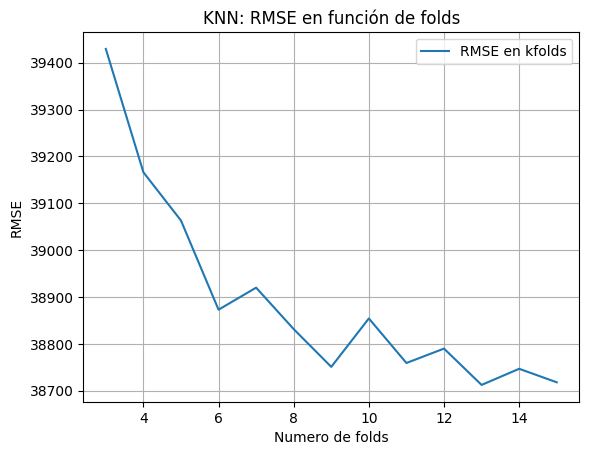

Cantidad de folds optima: 13 38712.247842333985


In [52]:
# Creo un modelo KNN regresor y ajustamos la cantidad de folds
knn_regressor = KNeighborsRegressor().fit(x_train_knn, y_train_knn)
y_pred_knn=knn_regressor.predict(x_test_knn)
y_pred_knn


def errores_modelo( y_pred, y_test):
  mse = metrics.mean_squared_error(
          y_true  = y_test_knn,
          y_pred  = y_pred,
          squared = True
        )

  rmse = metrics.mean_squared_error(
          y_true  = y_test_knn,
          y_pred  = y_pred,
          squared = False
         )

  print(f"El error (mse) de test es: {mse}")
  print(f"El error (rmse) de test es: {rmse}")

errores_modelo( y_pred_knn, y_test_knn)
knn_regressor.score(x_test_knn,y_test_knn)

mean_scores_kfold = []
for i in range(3,16):
  scores = cross_val_score(knn_regressor, x_test_knn, y_test_knn, scoring="neg_mean_squared_error", cv=i)
  rmse_scores = np.sqrt(-scores)
  print(i,"folds:",rmse_scores.mean())

  mean_scores_kfold.append(rmse_scores.mean())
  #print(i, "| Mean:", round(scores.mean(),3), " | std:", round(scores.std(),3))


plt.plot(range(3,16), mean_scores_kfold, label="RMSE en kfolds")
plt.xlabel("Numero de folds")
plt.ylabel("RMSE")
plt.grid()
plt.legend()
plt.title("KNN: RMSE en función de folds")
plt.show()

print("Cantidad de folds optima:", mean_scores_kfold.index(min(mean_scores_kfold)) + 3,min(mean_scores_kfold))

#### Ajustamos cantidad de vecinos óptima

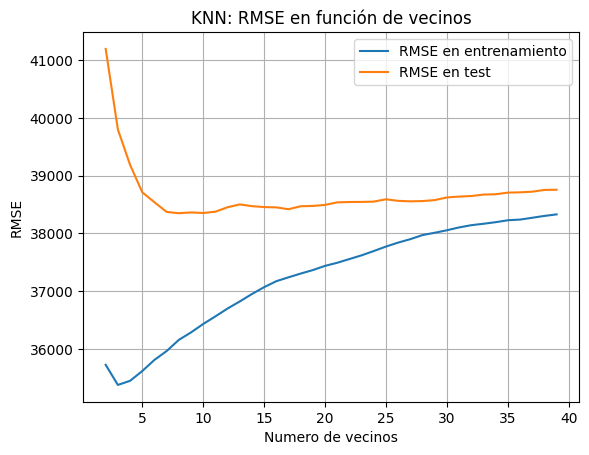

Cantidad de vecinos optima: 8 38349.98137521139 Score entrenamiento:  36159.022888700354


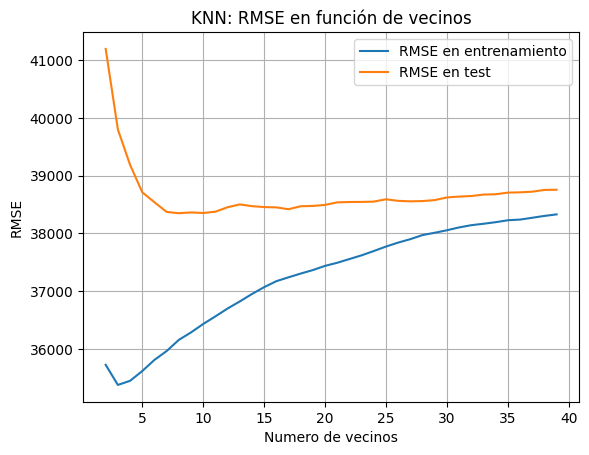

Cantidad de vecinos optima: 8 38349.98137521139 Score entrenamiento:  36159.022888700354


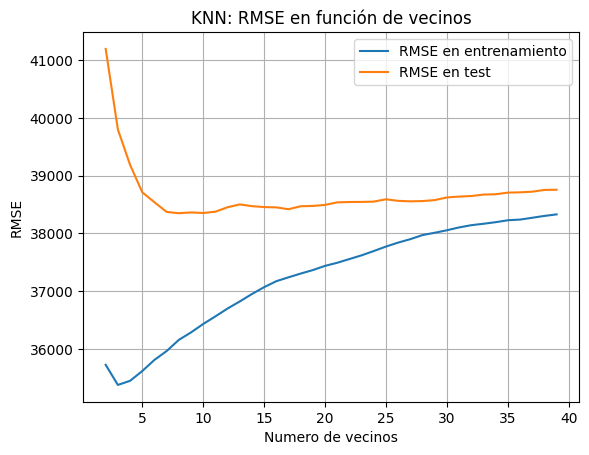

Cantidad de vecinos optima: 8 38349.98137521139 Score entrenamiento:  36159.022888700354


In [29]:
# Encontrando la mejor cantidad de vecinos con minkowski p=2. Con cross validation
def vecinos_segun_hp_cv_c_graf(pesos,algoritmo):
  scores_entrenamiento_mean = []
  scores_test_mean = []
  scores_entrenamiento_std = []
  scores_test_std = []

  vecinos = np.arange(2,40,1)
  for vecino in vecinos:
    knn_tuning = KNeighborsRegressor(n_neighbors=vecino).fit(x_train_knn, y_train_knn)
    cross_val_train = cross_val_score(knn_tuning, x_train_knn, y_train_knn, scoring="neg_mean_squared_error", cv=13)
    cross_val_test = cross_val_score(knn_tuning, x_test_knn, y_test_knn, scoring="neg_mean_squared_error", cv=13)
    scores_entrenamiento_mean.append(np.sqrt(-cross_val_train).mean())
    scores_test_mean.append(np.sqrt(-cross_val_test).mean())
    scores_entrenamiento_std.append(np.sqrt(-cross_val_train).std())
    scores_test_std.append(np.sqrt(-cross_val_test).mean())

#    print(vecino,"vecinos | score test mean y std:",round(np.sqrt(-cross_val_test).mean(),3),round(np.sqrt(-cross_val_test).std(),3), "| score train mean y std: ",round(np.sqrt(-cross_val_train).mean(),3),round(np.sqrt(-cross_val_train).std(),3))



  plt.plot(vecinos, scores_entrenamiento_mean, label="RMSE en entrenamiento")
  plt.plot(vecinos, scores_test_mean, label="RMSE en test")
  plt.xlabel("Numero de vecinos")
  plt.ylabel("RMSE")
  plt.legend()
  plt.grid()
  plt.title("KNN: RMSE en función de vecinos")
  plt.show()

  print("Cantidad de vecinos optima:", scores_test_mean.index(min(scores_test_mean)) + 2,min(scores_test_mean), "Score entrenamiento: ", scores_entrenamiento_mean[scores_test_mean.index(min(scores_test_mean))])

vecinos_segun_hp_cv_c_graf("uniform","auto")
#vecinos_segun_hp_cv_c_graf("uniform","brute")
#vecinos_segun_hp_cv_c_graf("distance","brute")

In [28]:
# Encontrando la mejor cantidad de vecinos con minkowski p=2
def vecinos_segun_hp(pesos,algoritmo,potencia,tamaño_hoja,cant_vecinos):
  knn_tuning = KNeighborsRegressor(n_neighbors=cant_vecinos,weights=pesos,algorithm=algoritmo,p=potencia).fit(x_train_knn, y_train_knn)
  print("Resultado en test: ",knn_tuning.score(x_test_knn,y_test_knn),"Resultado en entrenamiento:",knn_tuning.score(x_train_knn,y_train_knn))

for i in range(1,2):
  print("Potencia:",i)
  vecinos_segun_hp("uniform","brute",i,30,8)
  vecinos_segun_hp("distance","brute",i,30,8)


Potencia: 1
Resultado en test:  0.6775012499353976 Resultado en entrenamiento: 0.7524697807169061
Resultado en test:  0.750911527047413 Resultado en entrenamiento: 0.9945625195786439


#### Análisis final de errores

In [46]:
# Analisis final.
knn_final = KNeighborsRegressor(n_neighbors=8).fit(x_train_knn, y_train_knn)
score_train = knn_final.score(x_train_knn,y_train_knn)
score_test = knn_final.score(x_test_knn,y_test_knn)
score_cross_validate = np.sqrt(-cross_val_score(knn_final, x_test_knn, y_test_knn, scoring="neg_mean_squared_error", cv=13))

errores_modelo(knn_final.predict(x_test_knn),y_test_knn)
print("Entrenamiento:",round(score_train,4),"Test:",round(score_test,4),"Cross-validation",round(score_cross_validate.mean(),2))


El error (mse) de test es: 1207436769.1029618
El error (rmse) de test es: 34748.19087525222
Entrenamiento: 0.751 Test: 0.6766 Cross-validation 38349.98


In [11]:
# Comparativa con modelo lineal
lr_model = LinearRegression().fit(x_train_knn, y_train_knn)
y_pred_lr = lr_model.predict(x_test_knn)

errores_modelo( y_pred_lr, y_test_knn)
lr_model.score(x_test_knn,y_test_knn)

El error (mse) de test es: 1430936225.65424
El error (rmse) de test es: 37827.717690263045


0.6167414947540028